In [10]:
import tensorflow as tf

In [11]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
# Import TensorFlow and tf.keras

from matplotlib.pyplot import imshow
from numpy.random import default_rng

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from tensorflow import keras


from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from keras._tf_keras.keras.preprocessing import image
from keras._tf_keras.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Input, Dense, Activation, Flatten, Conv2D
from tensorflow.python.keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.python.keras.models import Model

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential

from tensorflow.python.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras._tf_keras.keras.optimizers import Adam, SGD
from keras._tf_keras.keras.applications import mobilenet
from keras._tf_keras.keras.applications.mobilenet import preprocess_input

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [12]:
inputPath = r"D:\DoAnChuyenNganh_TTNT"

In [13]:
#load only persons with more than "number_of_images"
number_of_images = 50
aug_multiplier = 10
iter_csv = pd.read_csv(inputPath+"/lfw_allnames.csv", iterator=True, chunksize=1000)
df = pd.concat([chunk[chunk['images'] > number_of_images] for chunk in iter_csv])
df.head()

,name,images
373,Ariel_Sharon,77
1047,Colin_Powell,236
1404,Donald_Rumsfeld,121
1871,George_W_Bush,530
1892,Gerhard_Schroeder,109


In [14]:
df.shape[0]

12

In [16]:
imagesFolder = inputPath+"/lfw_funneled/"
imagesFolder

'D:\\DoAnChuyenNganh_TTNT/lfw_funneled/'

In [19]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse_output=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print(onehot_encoded)

    y = onehot_encoded
    print(y.shape)
    return y

In [20]:
tr_len = (df.shape[0]*number_of_images*aug_multiplier)-(number_of_images*df.shape[0])
y_tr = ["" for x in range(tr_len)]

ts_len = df.shape[0]*number_of_images
y_ts = ["" for x in range(ts_len)]

In [21]:
df['name']

373          Ariel_Sharon
1047         Colin_Powell
1404      Donald_Rumsfeld
1871        George_W_Bush
1892    Gerhard_Schroeder
2175          Hugo_Chavez
2288       Jacques_Chirac
2468        Jean_Chretien
2682        John_Ashcroft
2941    Junichiro_Koizumi
4963      Serena_Williams
5458           Tony_Blair
Name: name, dtype: object

In [22]:
tr_len

5400

In [23]:
rng = default_rng()
X_rand = rng.choice(number_of_images*aug_multiplier, size=number_of_images, replace=False)
X_rand.sort()
X_rand

array([ 15,  19,  31,  43,  44,  46,  57,  73,  97, 115, 117, 121, 128,
       161, 177, 190, 191, 193, 200, 206, 207, 228, 239, 269, 275, 276,
       277, 293, 297, 300, 309, 312, 323, 330, 331, 376, 377, 390, 394,
       396, 437, 441, 454, 459, 479, 483, 488, 492, 494, 499])

In [29]:
def prepareImages(df, m):
    print("Preparing images")
    X_train = np.zeros((tr_len, 250, 250, 3))
    X_test = np.zeros((ts_len, 250, 250, 3))
    
    count = 0
    ts_idx = 0
    tr_idx = 0
    
    for personFolder in df['name']:
        print(personFolder)
        #count = 0
        rng = default_rng()
        X_rand = rng.choice(number_of_images*aug_multiplier, size=number_of_images, replace=False)
        X_rand.sort()
        rand_idx = 0
        person_images_idx = 0
        for img in os.listdir(imagesFolder+"/"+personFolder):
            
            #load images into images of size 100x100x3
            img = image.load_img(imagesFolder+personFolder+"/"+img, target_size=(250, 250, 3))
            x = image.img_to_array(img)
            x = preprocess_input(x)
            if (person_images_idx == X_rand[rand_idx]):
                X_test[ts_idx] = x
                y_ts[ts_idx] = personFolder
                ts_idx += 1
                #print(ts_idx)
                if rand_idx<number_of_images-1:
                    rand_idx += 1
                
            else:
                X_train[tr_idx] = x
                #print("else\n")
                y_tr[tr_idx] = personFolder
                tr_idx += 1
            count += 1
            person_images_idx += 1
            #print(count)
            if (count % ((number_of_images*aug_multiplier)) == 0):
                print("Processing image: ", count, ", ", img)
                break
            
    
    return X_train, X_test

In [30]:
X_train,X_test = prepareImages(df, df.shape[0]*number_of_images*aug_multiplier)

y_train = prepare_labels(y_tr)

y_test = prepare_labels(y_ts)

df['name']

Preparing images
Ariel_Sharon
Colin_Powell
Donald_Rumsfeld
George_W_Bush
Processing image:  500 ,  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x24318E9C880>
Gerhard_Schroeder
Hugo_Chavez
Jacques_Chirac
Jean_Chretien
John_Ashcroft
Junichiro_Koizumi
Serena_Williams
Tony_Blair
Processing image:  1000 ,  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x2437F190E80>
[1 1 1 ... 0 0 0]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(5400, 13)
[ 1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  5  5  5  5  5  5  6  6  6  7  7  8  8  8  8  9  9  9
  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 12 12
 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

373          Ariel_Sharon
1047         Colin_Powell
1404      Donald_Rumsfeld
1871        George_W_Bush
1892    Gerhard_Schroeder
2175          Hugo_Chavez
2288       Jacques_Chirac
2468        Jean_Chretien
2682        John_Ashcroft
2941    Junichiro_Koizumi
4963      Serena_Williams
5458           Tony_Blair
Name: name, dtype: object

In [31]:
y_train.shape

(5400, 13)

In [32]:
X_train.shape

(5400, 250, 250, 3)

In [33]:
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator()
print(datagen)

In [34]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [35]:
nr_classes = y_train.shape[1]
model = mobilenet.MobileNet(input_shape=(250, 250, 3), weights=None, include_top=True, alpha=1., classes=nr_classes)
model.compile(optimizer=Adam(learning_rate=0.0008), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])
#model.load_model("AI\algorithm\working/model_25gpunotop.h5")
print(model.summary())

Model: "mobilenet_1.00_250"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 125, 125, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 125, 125, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 125, 125, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 125, 125, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 125, 125, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 62, 62, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 62, 62, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 62, 62, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 62, 62, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,242,189 (12.37 MB)

 Trainable params: 3,220,301 (12.28 MB)

 Non-trainable params: 21,888 (85.50 KB)

None


In [36]:
len(X_train)

5400

In [37]:
BS=100
steps = len(X_train) / BS
steps

54.0

In [ ]:
steps = len(X_train) / BS

# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)
# history = model.fit(datagen.flow(X_train, y_train, batch_size=BS), validation_data=(X_test, y_test), epochs=1, verbose=1)
# model.save(r"../working/model_25gpunotop.h5")
history = model.fit(datagen.flow(X_train, y_train, batch_size=BS), validation_data=(X_test, y_test), epochs=1, verbose=1)

In [38]:
import cv2
from tensorflow.python.keras.models import load_model  
import numpy as np

In [ ]:
face_deteactor = cv2.CascadeClassifier(r"D:\DoAnChuyenNganh_TTNT\AI\algorithm\haarcascades\haarcascade_frontalface_alt.xml")

# Load model  
model = load_model(r"D:\DoAnChuyenNganh_TTNT\AI\algorithm\AI\algorithm\working\model_25gpunotop.h5")  

# Mở camera  
camera = cv2.VideoCapture(0)  

while True:  
    ok, frame = camera.read()  
    if not ok:  
        print("Failed to capture video")  
        break  
    
    # Phát hiện khuôn mặt  
    faces = face_deteactor.detectMultiScale(frame, 1.3, 5)  

    for (x, y, w, h) in faces:  
        roi = cv2.resize(frame[y:y+h, x:x+w], (250, 250))  # Resize mẫu khuôn mặt  
        roi = roi / 255.0  # Chuẩn hóa dữ liệu (nếu mô hình đã được huấn luyện với dữ liệu chuẩn hóa)  
        roi = np.reshape(roi, (-1, 250, 250, 3))  # Thay đổi kích thước về dạng (batch_size, height, width, channels)  
        
        # Dự đoán  
        result = model.predict(roi)  
        
        # Xử lý kết quả dự đoán  
        predicted_class = np.argmax(result, axis=1)  # Lấy lớp dự đoán cao nhất  
        cv2.rectangle(frame, (x, y), (x+w, y+h), (128, 255, 50), 1)  
        cv2.putText(frame, str(predicted_class), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)  # Vẽ nhãn  

    # Hiện thị khung hình  
    cv2.imshow('frame', frame)  
    
    if cv2.waitKey(1) & 0xFF == ord("q"):  
        break  

# Giải phóng camera  
camera.release()  
cv2.destroyAllWindows()  

In [ ]:
models = models.load_model(r"D:\DoAnChuyenNganh_TTNT\AI\algorithm\AI\algorithm\working\model_25gpunotop.h5")

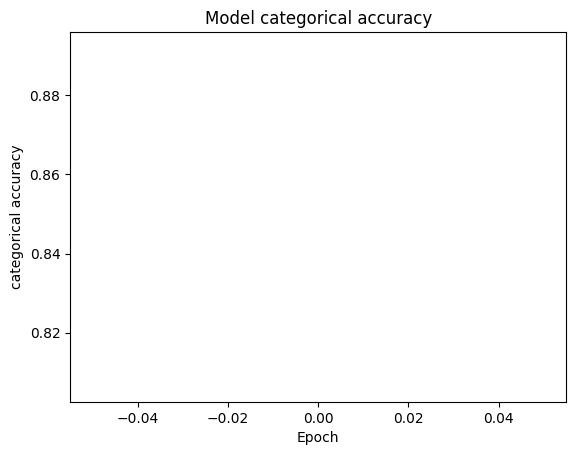

In [43]:
plt.plot(history.history['categorical_accuracy'])
plt.title('Model categorical accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('Epoch')
plt.show()

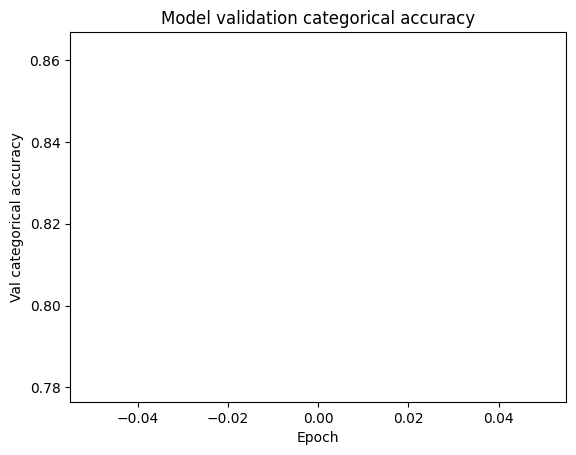

In [44]:
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model validation categorical accuracy')
plt.ylabel('Val categorical accuracy')
plt.xlabel('Epoch')
plt.show()

In [45]:
os.listdir(r"D:\DoAnChuyenNganh_TTNT\testimage")

[]

In [46]:
img = image.load_img(r"D:\DoAnChuyenNganh_TTNT\lfw_funneled\Serena_Williams\Serena_Williams_0052.jpg", target_size=(250, 250, 3))
x = image.img_to_array(img)
Xnew = x
#Xnew = preprocess_input(x)
Xtest = np.expand_dims(Xnew, axis=0)
ynew = model.predict(Xtest)
ynew

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.9696922 , 0.00197367, 0.0026795 , 0.00202379, 0.00147896,
        0.00197221, 0.00194449, 0.00193796, 0.00227272, 0.0028947 ,
        0.00212563, 0.00190273, 0.00710151]], dtype=float32)

In [47]:
Xnew.shape

(250, 250, 3)

In [ ]:
#model = mobilenet.MobileNet(input_shape=(224, 224, 3),include_top=True, alpha=1., weights=None, classes=y.shape[1])
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
#              metrics=[categorical_crossentropy, categorical_accuracy, top_5_accuracy])

In [48]:
out_name = "model_5adamaug00002knopre"

# model.load_weights("../input/model-50/model_50.h5")

In [49]:
Xtest = np.expand_dims(Xnew, axis=0)
ynew = model.predict(Xtest)
ynew

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[0.9696922 , 0.00197367, 0.0026795 , 0.00202379, 0.00147896,
        0.00197221, 0.00194449, 0.00193796, 0.00227272, 0.0028947 ,
        0.00212563, 0.00190273, 0.00710151]], dtype=float32)

In [50]:
ynew

array([[0.9696922 , 0.00197367, 0.0026795 , 0.00202379, 0.00147896,
        0.00197221, 0.00194449, 0.00193796, 0.00227272, 0.0028947 ,
        0.00212563, 0.00190273, 0.00710151]], dtype=float32)

In [51]:
# Create a converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Set quantize to true 
#converter.post_training_quantize=True
# Convert the model
tflite_model = converter.convert()
# Create the tflite model file
tflite_model_name = out_name+".tflite"
open(tflite_model_name, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp5k6dm1u6\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp5k6dm1u6\assets


Saved artifact at 'C:\Users\Admin\AppData\Local\Temp\tmp5k6dm1u6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 13), dtype=tf.float32, name=None)
Captures:
  2226460699360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2226461027744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2226461029152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2226461027392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2226461029680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2226461026688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2235461571280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2235461568288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2235461569872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2235461572336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2235

12854496

In [ ]:
#label_encoder.inverse_transform(df['name'])

In [52]:
model_json = model.to_json()
with open(out_name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(out_name+".weights.h5")

In [53]:
tf.saved_model.save(model, out_name+"_saved")

INFO:tensorflow:Assets written to: model_5adamaug00002knopre_saved\assets


INFO:tensorflow:Assets written to: model_5adamaug00002knopre_saved\assets


In [54]:
import tarfile

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
        
make_tarfile(out_name+"Tar", r"D:\DoAnChuyenNganh_TTNT\AI\algorithm\model_50adamaug00002knopre_saved")

In [55]:
# Create a converter
converter = tf.lite.TFLiteConverter.from_saved_model(r"D:\DoAnChuyenNganh_TTNT\AI\algorithm\model_50adamaug00002knopre_saved")
# Set quantize to true 
#converter.post_training_quantize=True
# Convert the model
tflite_model = converter.convert()
# Create the tflite model file
tflite_model_name = out_name+"fromSaved.tflite"
open(tflite_model_name, "wb").write(tflite_model)

97568

In [56]:
model.save(out_name+".h5", include_optimizer=True)

In [154]:
import cv2
from tensorflow.python.keras import layers, models

In [165]:
face_deteactor = cv2.CascadeClassifier(r"D:\DoAnChuyenNganh_TTNT\AI\algorithm\haarcascades\haarcascade_frontalface_alt.xml")

In [190]:
model = models.load_model(r"D:\DoAnChuyenNganh_TTNT\AI\algorithm\model_50adamaug00002knopreTar")

OSError: SavedModel file does not exist at: D:\DoAnChuyenNganh_TTNT\AI\algorithm\model_50adamaug00002knopreTar\{saved_model.pbtxt|saved_model.pb}

In [131]:
print(model)

None


In [191]:
file_path = r"D:\DoAnChuyenNganh_TTNT\AI\algorithm\model_5adamaug00002knopre.h5"
models.load_model(filepath=file_path, compile=True)

ValueError: ('Unrecognized keyword arguments:', dict_keys(['batch_shape']))

In [ ]:
face_deteactor = cv2.CascadeClassifier(r"D:\DoAnChuyenNganh_TTNT\AI\algorithm\haarcascades\haarcascade_frontalface_alt.xml")

camera = cv2.VideoCapture(0)

while True:
    ok, frame = camera.read()
    faces = face_deteactor.detectMultiScale(frame, 1.3, 5)

    for (x, y, w, h) in faces:
        roi = cv2.resize(frame[y: y+h, x: x+w], (250,250))
        result = np.argmax(model.predict(roi.resize((-1, 250, 250, 3))))
        cv2.rectangle(frame, (x, y), (x+w, y+h), (128, 255, 50), 1)
        cv2.putText(frame, str(result))

    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

camera.release()
cv2.destroyAllWindows()